# Extracting motion from video clips
This script aims at extracting and comparing motion information from video clips.
Aiming at this objective, the Farneback algorithm for dense optical flow analysis is applied to each video. The result is a matrix of the same size as the video input containing a displacement vector in each field representing the displacement of visual targets in two subsequent frames. 
To simplify further processing two additional representations of the displacement matrices are computed, one only containing the direction information (displacement-only) and one only containing the length of the displacement vectors (displacement-strength) for each pixel.

1) Total amount of directed motion in one clip

To compute the total amount of directed motion in one clip a weighted histogram of displacement directions is computed for each frame. The displacement-only and the displacement-strength representations (see above) are used in this step.
On the scope of the whole clip the histograms are being summed up bin-wise. One ends up with a histogram of n bins representing the amount of directed motion in a video that relies within a predefined range (0 to 10 degrees). A value of 0 means that no motion in the respective direction was detected and high values represent large groups of pixels showing significant displacement.
Finally also a undirected motion score is computed by summing up the values of each bin.

2) Motion coherence in two clips

The second information computed is the coherence of motion in two clips. The measure of interest is the correlation in time of weighted motion directions in two clips. One ends up with a correlation coefficient for each range of motion directions (e.g. 0-10°) on the scope of two whole clips. A promising candidate for a single value indicator for coherence between two clips is the standard deviation of correlation coefficients.   

This script is free to use and modify. Please refer to the original version. Author: Michael Gerstenberger 2017.


## Setup
### Anaconda

For you to be able to run this script you will first have to download the Anaconda python-distribution. To open this notebook you have to open Jupyter-notebook that comes with the custom Anaconda installation (In Windows 10 you can simply type Jupyter notebook in the search box). Once opened you need to navigate to the folder containing this file to open it up. Anaconda also comes with the Jupyter QTConsole allowing you to directly access Python. This script uses the Python-port of the OpenCV library. Hence you need to download the latter. 

### Open-CV
In Windows 10 (version 9/2017) - having Python 3.5.2 and Anaconda 4.2.0 (64-bit) ready - executing the following code in the standard Windows-Console installed Open-CV for Python via Anaconda properly. Simply open up the command line (Type cmd in Windows 10 search bar) paste the following command and hit enter.

Feel free to modify this script by adding installation guides that worked on your system.

Having Open-CV installed you need to import it using the next line of code. You can run cells by selecting the cell and either using the play symbol in the edit-bar above or using the short-cut SHIFT-ENTER.

In [1]:
import cv2

Also you need to import some other libraries by excecuting the following cells.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1. The total amount of directed motion in one clip

To compute the motion between frames in a video you first have to load the clip and read the frames.
The following lines serve this process. Mind that with this code only the first two frames are compared and serves illustrative purpusos only. You need to change the path to the video file.

In [4]:
cap = cv2.VideoCapture("00_STH.mov")
#cap = cv2.VideoCapture("C:/Users/Eler/Desktop/fMRI scripts/k_back/movs/03_coh_normal/coh_90dg_13dots_tall.mov")
#cap = cv2.VideoCapture("C:/Users/Eler/Desktop/fMRI scripts/k_back/movs/08_dyl_faces/face_56.2.mov")
#cap = cv2.VideoCapture("C:/Users/Eler/Documents/Python Scripts/randomdot.avi")


ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

ret, frame2 = cap.read()
next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 2, 5, 1.2, 0)

### Computing direction and strength of motion in two subsequent frames
Now that we loaded two frames and computed dense optical flow we need to define a function that computes the measures we are interested in: The direction of displacement and the strength or distance of displacement the algorithm detected (The threshold is hard-coded at the moment. Adjust if necessary):

In [5]:
#Computes the main motion-measures for each pixel for each frame: 
# The strength of displacement (distance), the direction of displacement plus a thresholded direction matrix
def computeFrameMeasuresCorrected(pvrs, flow):
    dispStrength = np.empty(np.shape(prvs))
    dispDir = np.empty(np.shape(prvs))
    dispStrength.fill(-np.finfo('d').max)#Assign - Infinity
    dispDir.fill(-np.finfo('d').max)#Assign - Infinity
    for y in range(0, np.shape(flow)[0]): # For each pixel
        for x in range(0, np.shape(flow)[1]):
            dispStrength[y][x] = np.linalg.norm(flow[y][x]) #equivalent to sqrt(a^2+b^2)
            dispDir[y][x] = np.degrees(np.arctan2(flow[y][x][0],flow[y][x][1])) #returns direction of vector
    
    # Remove artefacts that result from the algortihm by thresholding
    thresDispDir = np.where(np.abs(dispStrength)>0.0001,dispDir[:],-np.finfo('d').max) #Assing direction only if Strength is above threshold
    #np.where(myBoolAry, 1,10) Assigns either  1 or 10 to output
    #np.where(myBoolAry, myValAry[:],-1) Assigns Value from myValAry at Position or -1
    return(dispStrength, dispDir, thresDispDir)

To give you an impression of how you can use this function and what the output of the Farneback algorithm looks like the following lines of code call it and print the computed representations.

Shape of video frames:
(400, 600)
Shape of dense optical flow output
(Coordinates [y][x][0] and [y][x][1])
(400, 600, 2)


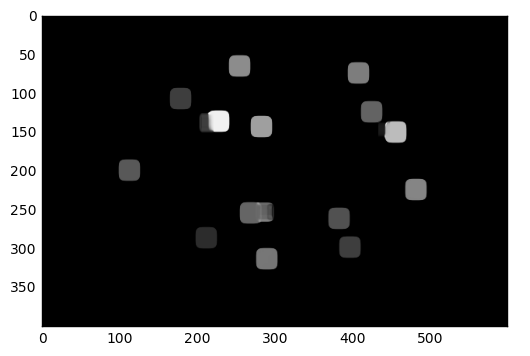

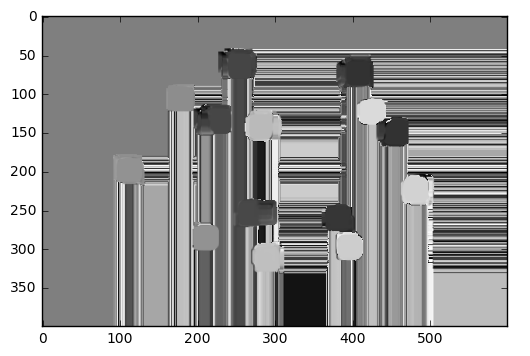

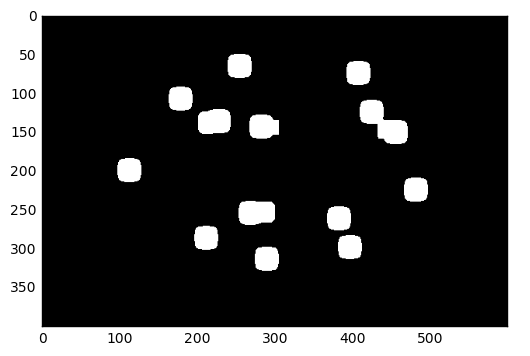

In [6]:
(dispStrength, dispDir, thresDispDir) = computeFrameMeasuresCorrected(prvs, flow)

print ("Shape of video frames:")
print(prvs.shape)

print ("Shape of dense optical flow output")
print ("(Coordinates [y][x][0] and [y][x][1])")
print(flow.shape)

plt.gray()
plt.imshow(dispStrength)
plt.show()
plt.imshow(dispDir)
plt.show()

plt.imshow(thresDispDir)
plt.show()

As you can see the algorithm detected the regions of moving dots. As the regions are relatively big closeby dots moving in different directions are pooled in one region such that a very bright area (strong motion) appears.

The second depiction shows the direction of motion. Artefacts of the algorithm become visible for regions where there is no motion at all. However you may see that the different directions were detected by the algorithm as the dots have different colors.

The third depiction shows a corrected i.e. thresholded verion. Only if the strength of motion exceeds a given threshold the direction is plotted. You can clearly see, that the algorithm detected dots moving in whatever direction (Difference in dot-color is invisible because Matplotlib ensures best visibility in the range of all grayvalues and what appears black was set to minus infinity).

### Computing the weighted histogram
The next few lines of code show how to compute a histogram of directions. 

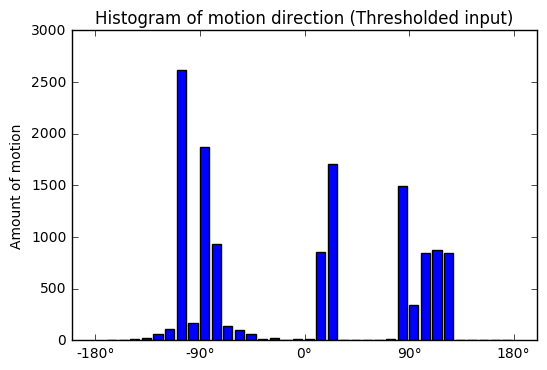

In [7]:
#You can use matplotlib hist directly but as we don't want to draw all the histograms later we use Numpy
bins = (np.arange(36)*10)-170 #start at -170. Go up in steps of 10 to 180
histOfThresholded, bin_edges = np.histogram(thresDispDir.flatten(),bins = bins)

def plotHistogram360(values, title):
    bins = (np.arange(36)*10)-170 #start at -170. Go up in steps of 10 to 180
    values = np.abs(values)#Discard minus
    y_pos = np.arange(len(values)) -17
    plt.bar(y_pos, values)
    plt.xticks([-18,-9, 0, 9, 18],['-180°',"-90°","0°","90°", "180°"])
    plt.ylabel('Amount of motion')
    plt.title(title)
    plt.show()

plotHistogram360(histOfThresholded, 'Histogram of motion direction (Thresholded input)')

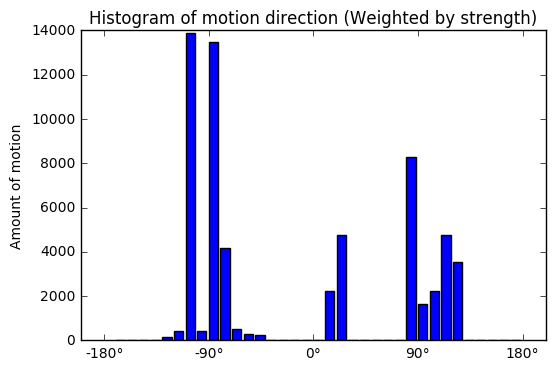

In [8]:
#You can use matplotlib hist directly but as we don't want to draw all the histograms later we use Numpy
bins = (np.arange(36)*10)-170 #start at -170. Go up in steps of 10 to 180
weightedHist, bin_edges = np.histogram(dispDir.flatten(),bins = bins, weights = dispStrength.flatten())

plotHistogram360(weightedHist,'Histogram of motion direction (Weighted by strength)')

Here you can see the two main directions of motion around -90 degrees and 90 degrees. Less motion was detected in the upwards and downwards direction as values around 0 and +180/-180 are relatively sparse).

## Computing the Total amount of directed motion in one clip

Now that we computed all the information we're interested in for two subsequent frames, it's time to put it all together to calculate the measures for the whole clip.

So let's have a function that does only compute what is needed for a weighted histogram to ensure computation time to be minimal.

In [9]:
bins = (np.arange(36)*10)-170 #start at -170. Go up in steps of 10 to 180

# Computes the weighted Histogram of movement direction using the output of the Farneback algorithm
def weightedHistogram(pvrs, flow):
    (dispStrength, dispDir) = computeFrameMeasures(pvrs,flow)
    weightedHist, bin_edges = np.histogram(dispDir.flatten(), weights = dispStrength.flatten(), bins = bins)
    return weightedHist

#Same as above but without thresholding. Compute displacementStrength and direction
def computeFrameMeasures(pvrs, flow):
    dispStrength = np.empty(np.shape(pvrs))
    dispDir = np.empty(np.shape(pvrs))
    dispStrength.fill(-np.finfo('d').max)#Assign - Infinity
    dispDir.fill(-np.finfo('d').max)#Assign - Infinity
    for y in range(0, np.shape(flow)[0]): # For each pixel
        for x in range(0, np.shape(flow)[1]):
            dispStrength[y][x] = np.linalg.norm(flow[y][x]) #equivalent to sqrt(a^2+b^2)
            dispDir[y][x] = np.degrees(np.arctan2(flow[y][x][0],flow[y][x][1])) #returns direction of vector
    return(dispStrength, dispDir)

Again it's time to put things together. Now we load the video again and compute the weighted Histogram for all pairs of subsequent frames. Be aware that this process will up to 5 minutes given the 2 seconds video were using.

In [10]:
def processMotionInClip(filepath):
    cap = filepath
    
    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    
    frameHistMap = {}

    currentFrame = 0
    while (True): #Continue looping until break
        ret, frame2 = cap.read()
        #if currentFrame == 20: #DEBUGGING
        #    break

        if ret == False: #There is no frame anymore
            print("Reached end of video")
            break
        else:
            print("Loading frame")

            next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 2, 5, 1.2, 0)
            frameHistMap[currentFrame] = weightedHistogram(prvs, flow)
            prvs = next
            currentFrame += 1
            
            
    
    return frameHistMap
            

In [12]:
file = cv2.VideoCapture("00_STH.mov")
#filepath = cv2.VideoCapture("C:/Users/Eler/Desktop/fMRI scripts/k_back/movs/03_coh_normal/coh_90dg_13dots_tall.mov")
#filepath = cv2.VideoCapture("C:/Users/Eler/Documents/Python Scripts/randomdot.avi")
myMap = processMotionInClip(file)

Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loadin

To obtain a measure for the whole viedeo we combine the histograms by adding up and averaging. Mind the limits of double-values.

In [13]:
def averageHistogram(myMap):
    averageHist = np.zeros(len(myMap[0]))
    for x in range(0,len(myMap)):
        averageHist = averageHist + myMap[x]
    averageHist /= len(myMap)
    return averageHist

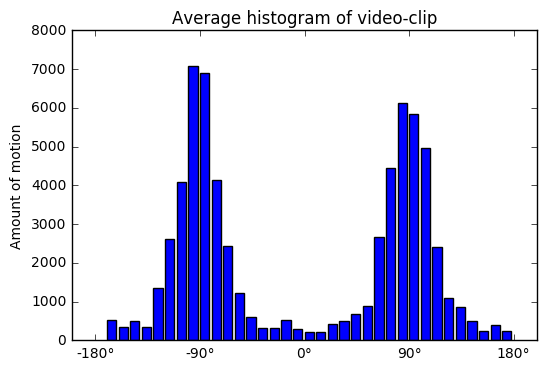

In [14]:
averageHist = averageHistogram(myMap)
plotHistogram360(averageHist,'Average histogram of video-clip')

Here we can clearly identify two peaks. One around minus 90 degrees and one around 90 degrees. These peaks represent motion in the rightwards and leftwards direction. As the dots in the input video indeed predominantly move in these directions this result meets our expectations.

Also we compute a measure for the general amount of motion in the video. To be meaningfully interpretable this value should be put into relation with other videos' value.

In [15]:
motionScore = 0
for x in range(len(averageHist)):
    motionScore += averageHist[x]  
motionScore /= len(averageHist)
print(motionScore)

1897.8190012578848


To process multiple videos one could simply loop through the files calling processMotionInClip with each filepath compute the motionscore and save all results.

# Motion correlation within and between videos

The data we extract from the videos doesn't ofcourse only allow to inspect motion properties of videos in isolation.
It also allows to investigate if motion patterns across videos correlate in time. Also it allows to invesigate if different motion directions occur together within one video.

To demonstrate how to compute the mentionned correlation we first have to load a second video and compute the motion parameters.

In [16]:
file = cv2.VideoCapture("coh_90dg_13dots_tall.mov")
#filepath = cv2.VideoCapture("C:/Users/Eler/Documents/Python Scripts/randomdot.avi")
#filepath = cv2.VideoCapture("C:/Users/Eler/Documents/Python Scripts/00_STH.mov")

mySecondMap = processMotionInClip(file)

Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loadin

Just to have an impression what the motion looks like we perform the motion analysis on the whole-video-scope. We compute and display the average histogram.

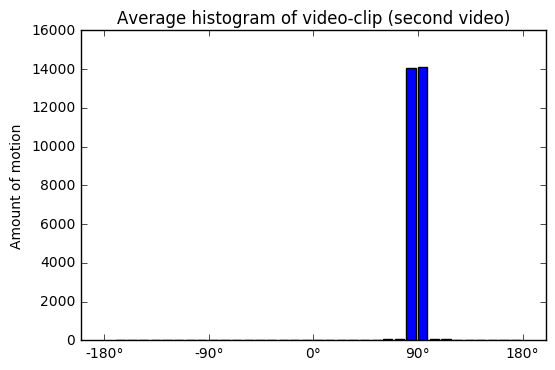

In [17]:
plotHistogram360(averageHistogram(mySecondMap),'Average histogram of video-clip (second video)')

Now we loop through all frames' histograms of both videos to and save the values to an array each. These arrays will be stored in a python list.

In [18]:
#To contain values to be correlated (one direction across videos) in a Numpy array each
def combineHistogramsOfVideosFrames(myMap,mySecondMap):
    motionAcrossVideosForAllVideos = []

    #Compute smaller number of frames in both videos
    frameMax = np.min([len(myMap),len(mySecondMap)])

    # Add first video across-frames for each direction
    for dir in range(0, len(myMap[0])):#loop through directions
        motionAcrossVideos = []
        for frame in range(0, frameMax):
            motionAcrossVideos.append(myMap[frame][dir])
        motionAcrossVideosForAllVideos.append(np.array(motionAcrossVideos))

    # Add second video across-frames for each direction 
    for dir in range(0, len(mySecondMap[0])):#loop through directions
        motionAcrossVideos = []
        for frame in range(0,frameMax):
            motionAcrossVideos.append(mySecondMap[frame][dir])
        motionAcrossVideosForAllVideos.append(np.array(motionAcrossVideos))
    return motionAcrossVideosForAllVideos

motionAcrossVideosForAllVideos = combineHistogramsOfVideosFrames(myMap,mySecondMap)

For a better understanding the resulting python-list is plotted below. It serves as the input to the function computing a cross correlation matrix across all directions-across-time of both videos.

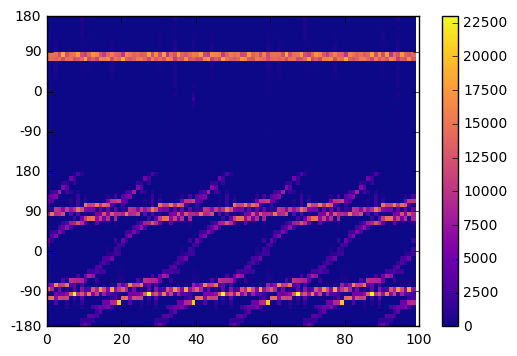

In [19]:
# plotting the correlation matrix
from pylab import pcolor, show, yticks, xticks, colorbar
pcolor(motionAcrossVideosForAllVideos, cmap = 'plasma')
yticks([0,8,17,26,35,44,53,62,70],[-180,-90,0,90,180,-90,0,90,180])

colorbar()
show()

In the upper half we see video2 that shows a uniform motion pattern across all frames (from left to righ).
In the lower half one may identify repetitive patterns of detected motion. They result from the dots making up a sphere moving to positions others have been at before.

In [20]:
crossCorrelationMatrix = np.corrcoef(motionAcrossVideosForAllVideos)

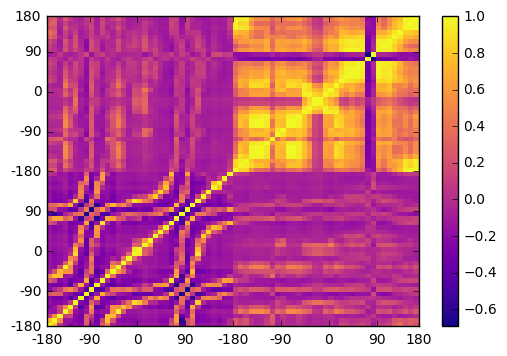

In [21]:
# plotting the correlation matrix
from pylab import pcolor, show, colorbar
pcolor(crossCorrelationMatrix, cmap = 'plasma')
xticks([0,8,17,26,35,44,53,62,70],[-180,-90,0,90,-180,-90,0,90,180])
yticks([0,8,17,26,35,44,53,62,70],[-180,-90,0,90,-180,-90,0,90,180])
colorbar()

show()

In the visualization of the cross-correlation matrix one may identify four quadrants.

1) The lower left quadrant shows the correlation in time of the 35 motion directions within the first video.

2) The upper right quadrant shows the correlation in time of the 35 motion directions within the second video.

3) The upper left and the lower right quadrant show the correlation of motion directions in time across both vidos.

### Another example

While the correlation of motion directions within videos reveals patterns of coocurring movement directions the correlation across videos is not very revealing. No isolated high correlating regions indicate certain movement directions in video 1 cooccur with the same or other movement directions in 2. This meets our expectations as both videos showed a uniform motion and therefore there was little variance in motion directions between frames such that our approach couldn't detect a well defined correlation between videos.

Therefore the same algorithm may be applied to videos showing coherent motion: Two pendulums swinging in the same frequency. First we load the video-frame's histograms.

In [ ]:
pendulum1MotionHistMap = processMotionInClip(cv2.VideoCapture('pendel1.mp4'))
pendulum2MotionHistMap = processMotionInClip(cv2.VideoCapture('pendel2.mp4'))


Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame
Loading frame


Now we compute the cross correlation matrix and print the result.

In [ ]:
crossCorrelationMatrix2 = np.corrcoef(combineHistogramsOfVideosFrames(pendulum1MotionHistMap,pendulum2MotionHistMap))
corrAcrossVids34 = crossCorrelationMatrix2[:35,35:]

from pylab import pcolor, show, colorbar
pcolor(crossCorrelationMatrix2, cmap = 'plasma')
xticks([0,8,17,26,35,44,53,62,70],[-180,-90,0,90,180,-90,0,90,180])
yticks([0,8,17,26,35,44,53,62,70],[-180,-90,0,90,180,-90,0,90,180])
colorbar()
show()

pcolor(corrAcrossVids34, cmap = 'plasma')
yticks([0,8,17,26,35],[-180,-90,0,+90,+180])
xticks([0,8,17,26,35],[-180,-90,0,+90,+180])
colorbar()
show()

Already the visual inspection reveals that one finds stroger cross-correlation coefficients between video 3 and 4 as compared to the previously examined videos. Also the distribution in the cross correlation matrix shows a more revealing pattern as well defined regions rather then uniform horizontal and vertical lines appear.

The distribution of correlation coefficients is more closely examinded with the next lines of code.

In [ ]:
print('Maximal value in video 3 vs. 4 (pendulum) motion direction crosscorrelation: ', 
      np.max(corrAcrossVids34))
import matplotlib.pyplot as plt
plt.hist(crossCorrelationMatrix[:35,35:])
plt.xlim(-1.0,1.0)
plt.show()

plt.hist(corrAcrossVids34)
plt.xlim(-1.0,1.0)
plt.show()

pcolor((corrAcrossVids34>.6) | (corrAcrossVids34<-.6), cmap = 'plasma')
yticks([0,8,17,26,35],[-180,-90,0,+90,+180])
xticks([0,8,17,26,35],[-180,-90,0,+90,+180])
show()

print("95th percentile of video 1 vs. 2 and video 3 vs. 4 motion direction crosscorrelation:")
print(np.percentile(crossCorrelationMatrix[:35,35:].flatten(),95))
print(np.percentile(corrAcrossVids34.flatten(),95))


print("5th percentile of video 1 vs. 2 and video 3 vs. 4 motion direction crosscorrelation:")
print(np.percentile(crossCorrelationMatrix[:35,35:].flatten(),5))
print(np.percentile(corrAcrossVids34.flatten(),5))

print("Standard deviation of video 1 and video 2 motion direction crosscorrelation:")
print(np.std(crossCorrelationMatrix[:35,35:].flatten()))
print(np.std(corrAcrossVids34.flatten()))

print("Number of crosscorrelations > 0.6 for video 1 vs. 2 and video 3 vs. 4")
print(np.bincount(crossCorrelationMatrix[:35,35:].flatten()>0.6, minlength=2)[1])
print(np.bincount(corrAcrossVids34.flatten()>0.6, minlength = 2)[1])





The analysis confirms that stronger crosscorrelations exist for the second pair of videos. The distribution is wider and has a larger standard deviation, the 5th and 95th percentile deviate stronger from 0 and the total number of crosscorrelation coefficients above 0.6 is larger in the second pair.
These values are candidates for a single measure for motion coherence in two videos.

In [ ]:
def weightedHistOfMotionDirsAcrossVids(video1MotionHistMap, video2MotionHistMap):
    myCrossCorrelationMatrix = np.corrcoef(
        combineHistogramsOfVideosFrames(video1MotionHistMap,video2MotionHistMap))
    corrAcrossVids = myCrossCorrelationMatrix[:35,35:]
    
    #Compute a weight matrix where all pixels are weighted according to the amount of 
    #motion in both videos
    filter1 = np.ones(np.shape(averageHistogram(video1MotionHistMap)))
    filter1 = filter1 * averageHistogram(video1MotionHistMap)[ :,None]
    filter2 = np.ones(np.shape(corrAcrossVids34))
    filter2 = filter2 * averageHistogram(video2MotionHistMap)[None, :]
    weightMatrix = filter1 * filter2
    #Z transformation
    weightMatrix = (weightMatrix - np.mean(weightMatrix))/ np.std(weightMatrix)
    
    #return weighted correlationMatrix across videos
    return (corrAcrossVids *weightMatrix)
    
plt.title('Correlation across videos\' frames\' motion directions' +
          '\n(weighted by amount of directed motion)')
pcolor(weightedHistOfMotionDirsAcrossVids(pendulum1MotionHistMap,pendulum2MotionHistMap), 
       cmap = 'plasma')
yticks([0,8,17,26,35],[-180,-90,0,+90,+180])
xticks([0,8,17,26,35],[-180,-90,0,+90,+180])
colorbar()
show()

In [ ]:
plotHistogram360(averageHistogram(pendulum2MotionHistMap),"Interesting")

Now that we defined a function to calculate the weighted motion corosscorrelation in time and saw a very clear result in the case of stimuli that were created to show strong correlation let's see what it looks like in the case of stimluli that are created as being uncorrelated: Our first two videos.

In [ ]:
plt.title('Correlation across videos\' frames\' motion directions' +
          '\n(weighted by amount of directed motion)')
pcolor(weightedHistOfMotionDirsAcrossVids(myMap,mySecondMap), 
       cmap = 'plasma')
yticks([0,8,17,26,35],[-180,-90,0,+90,+180])
xticks([0,8,17,26,35],[-180,-90,0,+90,+180])
colorbar()
show()

We see that weighted correlation values are a lot weaker (However the total amount of motion and hence the weights were larger in the first pair of videos). Moreover it looks as if negatively correlated pairs of motion directions rely right next to each other. One may assume that this is unlikely to happen in most naturalistic video scenes (they don't tend to be chaotic) and rather noise then a meaningful result. One may hence consider to smoothen the weighted crosscorrelation matrix using e.g. a gaussian kernel.